It's been 6 months since my last blog. There are multiple blog drafts to be honest, but many of them took a really long time to finish. I guess I should have sliced the material a bit to multiple blogs. Anyway in this blog, I want to show how to achieve more than 95% accuracy with just Macbook Air. So let's dig down to details.

This material originally comes [Deep Learning Lecture 4 from Udacity](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/4_convolutions.ipynb). In this blog,  Pickling, reformat, accuracy, and session are theirs, but the architecture is my own which is the core of Deep Learning. It's kind of refreshing because I have experience it before (yes, Andrew Ng's Coursera Machine Learning on Neural Network).
<!--TEASER_END-->

In [5]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

%matplotlib inline
import matplotlib.pyplot as plt
import string

The original MNIST dataset has been pickled and reshaped into training, validation and test set at [Lecture 1](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb). We have dataset with only A-J letters to predict (limited because of computing power).

In [6]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Let's plot the first three images in dataset.

In [31]:
def show_label_image(idx):
    print('Labels: ', string.ascii_uppercase[train_labels[idx]])
    return plt.imshow(train_dataset[idx])

Labels:  E


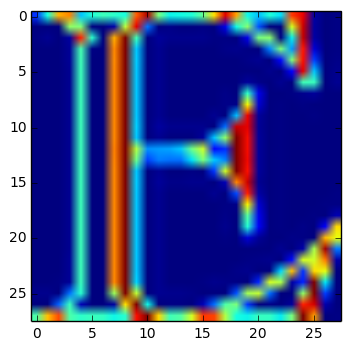

In [32]:
show_label_image(0);

Labels:  J


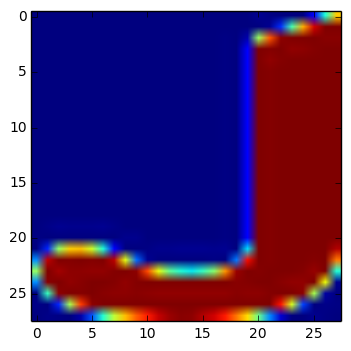

In [33]:
show_label_image(1);

Labels:  G


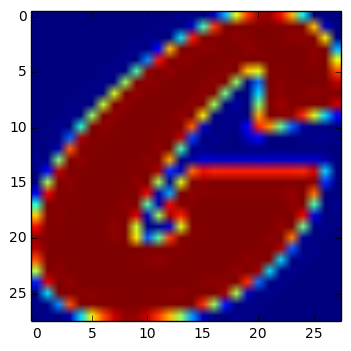

In [35]:
show_label_image(2);

Next, Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

There is two major section when running Tensorflow. The first one is how you describe the deep learning architecture in form of tensor graph. Since we only describe and compile the architecture, there's no computation going on. The second one is session. It's made to tell the graph to actually play and learning from the data. We can use the session to report the validation set. 

Okay, so this is where I play around over some parameters and deep learning architecture, which is where the real fun begin.

In [ ]:
batch_size = 128
regularization_c = 0.12
learning_rate_c = 0.4
num_steps = 15001

On machine learning side, there are these usual parameters that you have to tuned. Batch size tells you how many training set for the algorithm to tell at one step. Batching this lead you to stochastic gradient descent. Using smaller batch size makes the machine train faster, but less convergence to the true features that can predict the data. So you have to increase the number of steps to mitigate the issue. On the other hand, if you have bigger batch size, the machine train longer at each step, but converge at a less stochastic movement. So you have a smaller number of steps to train. I choose 128 images per step and 15000 number of steps.

And then there's also some regularization parameter that let machine penalize features that overmagnified (prevent overfitting). Learning rates also tells how faster you want machine learning to train. I choose 0.4 and decay exponentially until 300 steps.

In [ ]:
dropout_rate = 0.5
def get_relu(logits):
  relu = tf.nn.relu(logits)
  if train:
    return tf.nn.dropout(relu, dropout_rate)
  else:
    return relu

On the deep learning side, I also set dropout rate of 0.5. That means if one layer in neural network contains 100 activation units, at each step 50% of those units will be selected randomly and perform forward prop and backprop. Intuitively, the layer can't rely on particular activation unit to make a prediction. Like regularization, dropout is used to prevent overfitting.

Don't forget to disable dropout at validation and test set. Because you want 100% (instead of 50%) prediction power for your deep learning.

In [2]:
patch_size = 13
depth = 16

Now here is where we get the core parameters of deep learning. 

Convolutions and pooling in Tensorflow typically expect 4 inputs; data, kernel size, stride movement, and padding. There are additional weights (machine learning features) for convolutions. 

There is 2D patch(kernel) that stride over our images and summarize it by making smaller number of pixels but longer depth. This is what's called 2D Convolutions. Here you can see at first layer of 2D convolutions I make 13x13 2D patch and depth 16. That means, 28x28 images of grayscale (1x channel, instead of RGB 3x channels) will be made smaller to 16x16 but longer to 16 depth channels. So imagine 16 2D matrices of 16x16.

In [ ]:
pooling_size = 2

Another method called pooling used to summarize the 2D matrix to even smaller number of pixels. The advantage of pooling over convolutions is that machine doesn't require additional weights to tuned. The pooling, like it called, creates a pooling at every stride movement of the matrix, and determine which value in pixels get in, and who doesn't. Max pooling then choose whichever pixel value the most in 2D matrix. Another method is average pooling, where you average all values in the matrix and pass in result to the next stage. Note that pooling doesn't increase the depths.

In [ ]:
stride_movement = [1, 2, 2, 1]

We keep discussing stride movement for convolutions and pooling. It requires 4 shape value; stride movement over data, width, height, and depth.

`[1,2,2,1]` tells Tensorflow stride every data, stride every 2 width and height pixels, and stride every depth channels. This makes at every additional convolutions and pooling, 2D pixels gets halved.

There are two different kinds of padding, same padding and valid padding. In valid padding the corner of the kernel started at the corner of the image. This makes the center of the kernel started and finished not in the edge of the images. In same padding you add zeros padding in edges of your 2D matrices, so the center of the kernels started at the corner of 2D images. 

Different padding, kernel size and stride movement will determine the size of output matrices.

In [ ]:
num_hidden = 64
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))


def get_biases(shape):
    return tf.Variable(tf.constant(1.0, shape=[shape[-1]]))


def get_weights_biases(shape):
    weights = get_weights(shape)
    biases = get_biases(shape)
    return weights, biases

Finally, I created convenient functions to get weights and biases. So you can just input the shape of the matrix you want, and return tensor variable. There is 4 shape value for 2D convolutions; width, height, input channels, and output channels. Pooling doesn't requires weight and bias. And there are only two shape value for the fully connected layer and logits; the number of activation input and number of activation output. For the fully connected layer, I choose 64 number of activation units as these are the final number of depth channels. 

Here are layers of my deep learning architecture:

1. 2D Convolutions (k=13, s=1, padding=valid)
2. Max Pooling (k=2, s=2, padding=same)
3. 2D Convolution (k=2, s=2, padding=same)
4. Max Pooling (k=2, s=2, padding=same)
5. 1x1 Convolutions (k=1, s=1, padding=valid)
6. Fully Connected
7. Fully Connected 
8. Classifier

As we discussed with each of the layer, 2D image pixels gets halved at every additional layer.

```
28x28 (2D Conv) 
  --> 16x16 (Max Pooling) 
    --> 8x8 (2D Conv) 
      --> 4x4 (Max Pooling) 
        --> 2x2 (1x1 Conv) 
          --> 1x1 Fully connected
            --> 1x1 Fully connected
              --> Classifier
```

In return, the depths get increased at every additional convolution layer.

```
1 grayscale channel (2D Conv) 
  --> 16 (Max Pooling) 
    --> 16 (2D Conv) 
      --> 32 (Max Pooling) 
        --> 32 (1x1 Conv) 
          --> 64 (Fully Connected) 
            --> 64 (Fully Connected) 
              --> Classifier
```

This is why convolutions talk about pixels get summarized with an increased depth. Hopefully all of the necessary details explained, and this is what the actual tensor graph looks like.

In [14]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = get_weights([patch_size, patch_size, num_channels, depth])
  layer1_biases = tf.Variable(tf.zeros([depth]))

  layer3_weights, layer3_biases = get_weights_biases([4, 4, depth, depth*2])
  layer5_weights, layer5_biases = get_weights_biases([2, 2, depth*2, num_hidden])
  layer6_weights, layer6_biases = get_weights_biases([num_hidden, num_hidden])
  layer7_weights, layer7_biases = get_weights_biases([num_hidden, num_hidden])
  layer8_weights, layer8_biases = get_weights_biases([num_hidden, num_labels])
  
  # Model.
  def model(data, train=False):
        
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    hidden = tf.nn.relu(conv + layer1_biases)
    
    pool = tf.nn.max_pool(hidden, [1, pooling_size, pooling_size, 1], stride_movement, padding='SAME')
    hidden = tf.nn.relu(pool)
    
    conv = tf.nn.conv2d(hidden, layer3_weights, stride_movement, padding='SAME')
    hidden = tf.nn.relu(conv + layer3_biases)
    
    pool = tf.nn.max_pool(hidden, [1, pooling_size, pooling_size, 1], stride_movement, padding='SAME')
    hidden = tf.nn.relu(pool)
    
    conv = tf.nn.conv2d(hidden, layer5_weights, [1, 1, 1, 1], padding='VALID')
    hidden = tf.nn.relu(conv + layer5_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    def get_relu(logits):
      relu = tf.nn.relu(logits)
      if train:
        return tf.nn.dropout(relu, dropout_rate)
      else:
        return relu

    fully_connected = tf.matmul(reshape, layer6_weights) + layer6_biases
    hidden = get_relu(fully_connected)
    
    fully_connected = tf.matmul(hidden, layer7_weights) + layer7_biases
    hidden = get_relu(fully_connected)
    
    classifier = tf.matmul(hidden, layer8_weights) + layer8_biases
    
    return classifier
  
  # Training computation.
  logits = model(tf_train_dataset, train=True)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  l2_loss = loss + (regularization_c * tf.nn.l2_loss(layer8_weights))
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(learning_rate_c, global_step, 300, 0.99 )
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(l2_loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Now let's create a session to run the tensor graphs. You initialized the tensor variable before you run. Again, you can see the minibatch take turns at every step with offset. There is also `feed_dict` variable that let the data and labels injected at each session run. And we reported training score and validation score at each of the step, and test score at final step. Here the session runs and the reported accuracy.

In [9]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.763546
Minibatch accuracy: 10.2%
Validation accuracy: 10.0%
Minibatch loss at step 1000: 0.664659
Minibatch accuracy: 82.8%
Validation accuracy: 85.0%
Minibatch loss at step 2000: 0.428772
Minibatch accuracy: 87.5%
Validation accuracy: 86.2%
Minibatch loss at step 3000: 0.602961
Minibatch accuracy: 82.8%
Validation accuracy: 86.9%
Minibatch loss at step 4000: 0.684882
Minibatch accuracy: 77.3%
Validation accuracy: 77.7%
Minibatch loss at step 5000: 0.353280
Minibatch accuracy: 89.8%
Validation accuracy: 87.9%
Minibatch loss at step 6000: 0.346389
Minibatch accuracy: 89.1%
Validation accuracy: 88.5%
Minibatch loss at step 7000: 0.386851
Minibatch accuracy: 87.5%
Validation accuracy: 88.4%
Minibatch loss at step 8000: 0.351568
Minibatch accuracy: 89.1%
Validation accuracy: 88.8%
Minibatch loss at step 9000: 0.314128
Minibatch accuracy: 89.8%
Validation accuracy: 89.1%
Minibatch loss at step 10000: 0.338578
Minibatch accuracy: 88.3%
Validation accur

You can see that even at every 1000 steps, the validation can increase/decrease. This is the result of the mini batch gradient descent that perform stochastic movement to converge ultimate predictive power. Let's do some of the back of the envelope calculations.

We have 128 images and 15000 of steps to run. The number of images that the machine saw, 

In [4]:
128 * 15000

1920000

While we have 200,000 images, the machine at least saw one image,

In [6]:
1920000. / 200000

9.6

So the machine saw almost 10 times at each image. This is the same as running full dataset on just 10 steps. This is relatively small number, and so the machine has potential room to grow by just increasing number of steps, but resulting to longer time to compute.

# Postscript

Obviously, there are some missing details in this blog. Namely,

* End-to-end deep learning process
* Computation behind convolutions
* Neural Network definition
* Arithmetic to get required output number of pixels based on input size, kernel size, stride, padding
* Machine Learning classification of one-hot-encoding
* Softmax and Cross Entropy
* Non-linear function like relu(used in this blog), sigmoid and tanh.

While I would love talk about it, I prefer to keep this blog short. That material alone could be made for another blog. Here I just want to share my deep learning structure and reported accuracy. This is relatively simple deep learning architecture. There are hundreds of layer in deep learning architecture in major production to infer complex interaction in an image rather than simple letter recognition. And there is another thing called inception, that use various combination of pooling and convolutions in one layer. All of these require multiple GPU units for deep learning to train faster.

We also talked about pooling, convolutions, and fully connected. Hopefully you understand if you see other CNN deep learning architecture in the future. 

You can download this notebook and try it yourself. See if you can play around with the parameters and beat the accuracy in this blog. And if this blog still feels like missing some details to you, I encourage you to take [Deep Learning course by Google at Udacity](https://www.udacity.com/course/deep-learning--ud730). It has all the information you need and more.